## Preprocessed methylation quality control 

In [28]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/renkasik/Desktop/DSLS/dsls project


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
beta = pd.read_csv('preprocessed_methylation_data.csv', index_col=0)
print(beta.shape)


(189097, 766)


### Sample Distributions
Density plots

/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_4952/3845888862.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


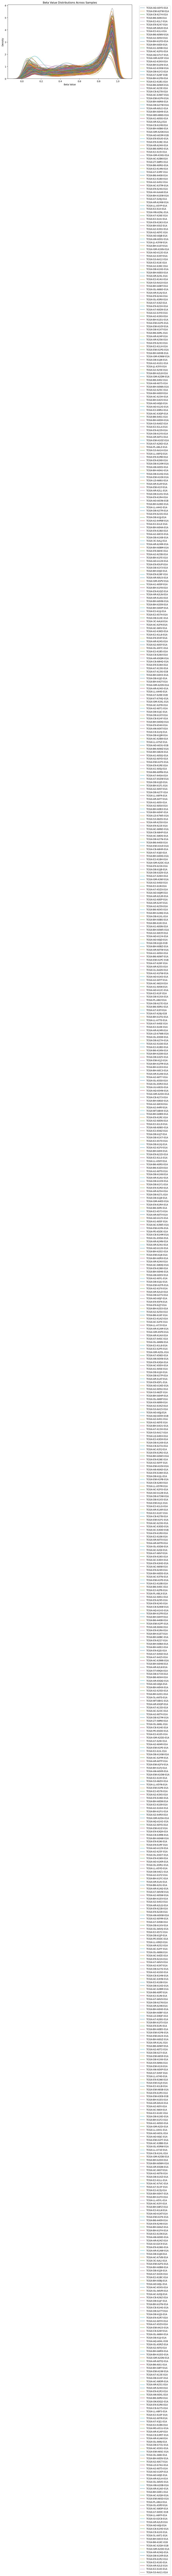

In [31]:
plt.figure(figsize=(10, 6))
for col in beta.columns:
    sns.kdeplot(beta[col].dropna(), label=col, linewidth=1)
plt.title("Beta Value Distributions Across Samples")
plt.xlabel("Beta Value")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

### Sample level stats
mean and std

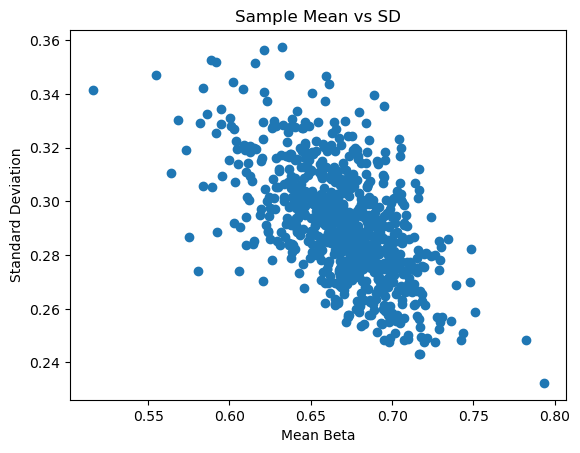

In [33]:
sample_means = beta.mean()
sample_sds = beta.std()

plt.scatter(sample_means, sample_sds)
plt.xlabel("Mean Beta")
plt.ylabel("Standard Deviation")
plt.title("Sample Mean vs SD")
plt.grid(False)
plt.show()

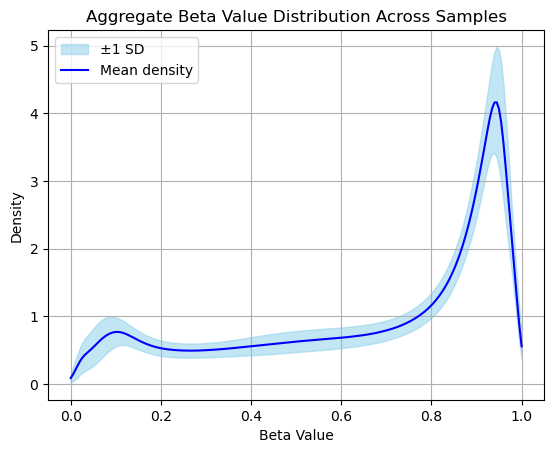

In [ ]:
x_vals = np.linspace(0, 1, 200)
all_densities = []

for col in beta.columns:
    dens = sns.kdeplot(beta[col].dropna(), bw_adjust=0.5).get_lines()[-1].get_data()
    plt.cla()  # clear to avoid stacking
    density = np.interp(x_vals, dens[0], dens[1], left=0, right=0)
    all_densities.append(density)

all_densities = np.vstack(all_densities)
mean_density = np.mean(all_densities, axis=0)
std_density = np.std(all_densities, axis=0)

#mean ± SD
plt.fill_between(x_vals, mean_density - std_density, mean_density + std_density,
                 color="skyblue", alpha=0.5, label="±1 SD")
plt.plot(x_vals, mean_density, color="blue", label="Mean density")
plt.xlabel("Beta Value")
plt.ylabel("Density")
plt.title("Aggregate Beta Value Distribution Across Samples")
plt.legend()
plt.grid(True)
plt.show()

### PCA for outliers

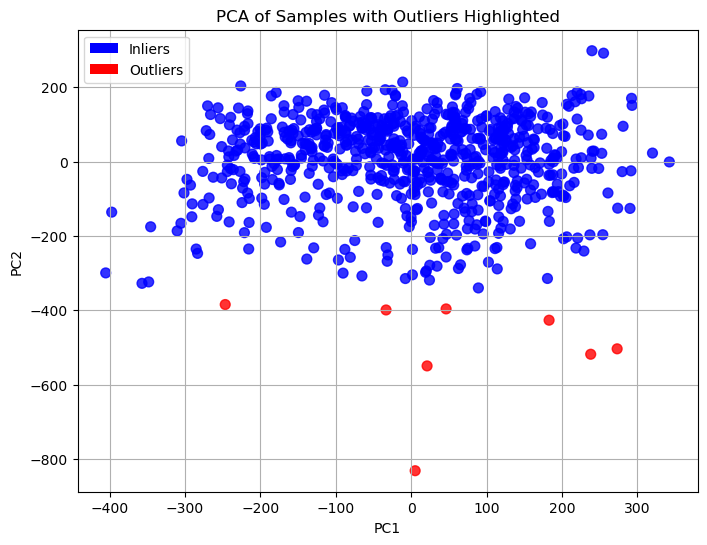

In [ ]:
# Scale and run PCA
scaler = StandardScaler()
beta_scaled = scaler.fit_transform(beta.T)  #transpose: rows = samples

pca = PCA(n_components=2)
components = pca.fit_transform(beta_scaled)

#outliers based on z-score threshold (e.g. >3 SDs)
z_pc1 = (components[:, 0] - components[:, 0].mean()) / components[:, 0].std()
z_pc2 = (components[:, 1] - components[:, 1].mean()) / components[:, 1].std()
outlier_mask = (np.abs(z_pc1) > 3) | (np.abs(z_pc2) > 3)

#assign colors
colors = np.where(outlier_mask, "red", "blue")


plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=colors, s=50, alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Samples with Outliers Highlighted")
plt.grid(True)


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Inliers'),
                   Patch(facecolor='red', label='Outliers')]
plt.legend(handles=legend_elements)
plt.show()

In [40]:
outlier_ids = beta.columns[outlier_mask].tolist()

outlier_ids
print(len(outlier_ids), "outliers detected based on PCA analysis.")
print(outlier_ids)

8 outliers detected based on PCA analysis.
['TCGA-B6-A0RG-01A', 'TCGA-S3-AA12-01A', 'TCGA-D8-A1XY-01A', 'TCGA-B6-A0X5-01A', 'TCGA-AO-A124-01A', 'TCGA-A7-A4SF-01A', 'TCGA-E2-A15K-01A', 'TCGA-LL-A6FP-01A']


8 outliers

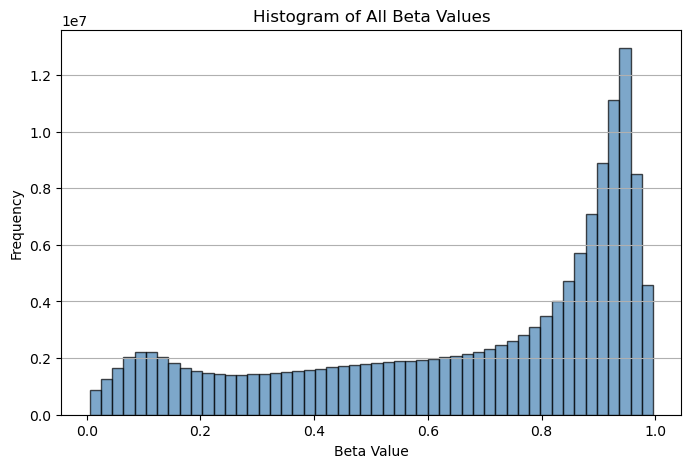

In [38]:
all_beta_values = beta.values.flatten()

# Drop any NaNs just in case
all_beta_values = all_beta_values[~pd.isna(all_beta_values)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_beta_values, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.title("Histogram of All Beta Values")
plt.xlabel("Beta Value")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [ ]:
clinical = pd.read_csv('preprocessed_clinical_data.csv')
print(clinical.columns)

Index(['sample', 'submitter_id', 'ajcc_pathologic_stage.diagnoses',
       'sample_type.samples', 'disease_type', 'primary_diagnosis.diagnoses',
       'ajcc_pathologic_t.diagnoses', 'ajcc_pathologic_n.diagnoses',
       'ajcc_pathologic_m.diagnoses'],
      dtype='object')


In [ ]:
stage_map = dict(zip(clinical['sample'], clinical['ajcc_pathologic_stage.diagnoses']))

beta_w_stage = pd.Series(beta.columns.map(stage_map), index=beta.columns, name='stage')



In [45]:
beta_long = beta.stack().reset_index()
beta_long.columns = ["CpG", "SampleID", "Beta"]
beta_long["Stage"] = beta_long["SampleID"].map(stage_map)

beta_long = beta_long.dropna(subset=["Stage"])

In [46]:
beta_long

,CpG,SampleID,Beta,Stage
0,cg00000029,TCGA-AQ-A0Y5-01A,0.123206,III
1,cg00000029,TCGA-EW-A2FW-01A,0.070247,II
2,cg00000029,TCGA-C8-A274-01A,0.095459,II
3,cg00000029,TCGA-B6-A0IK-01A,0.213110,III
4,cg00000029,TCGA-E2-A1L7-01A,0.239587,III
...,...,...,...,...
144848297,ch.9.2262725R,TCGA-E9-A1R2-01A,0.092650,III
144848298,ch.9.2262725R,TCGA-E2-A1IG-01A,0.064109,II
144848299,ch.9.2262725R,TCGA-AR-A2LE-01A,0.114382,I
144848300,ch.9.2262725R,TCGA-E2-A1IO-01A,0.110050,I


/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_4952/1266937733.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=beta_long, x="Stage", y="Beta", palette="Set3", inner="box")


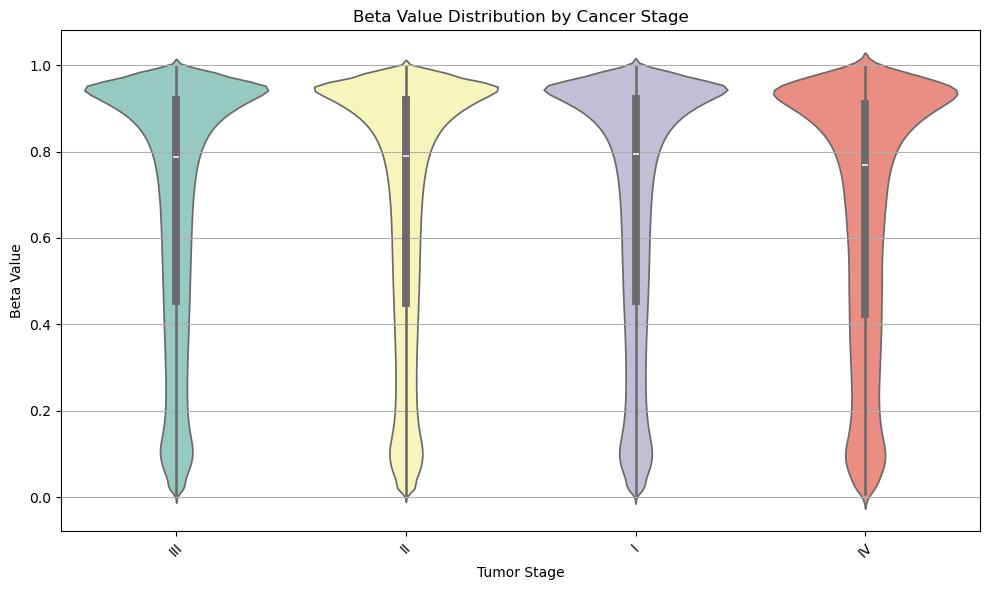

In [47]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=beta_long, x="Stage", y="Beta", palette="Set3", inner="box")
plt.title("Beta Value Distribution by Cancer Stage")
plt.xlabel("Tumor Stage")
plt.ylabel("Beta Value")
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()